In [8]:
import os
import config
os.chdir(config.PROJECT_ROOT_PATH)


import pathlib
import sys

if hasattr(sys.modules["__main__"], "get_ipython"):
    from tqdm import notebook as tqdm
else:
    import tqdm

from PyPDF2 import PdfMerger
import fitz
import json

from PIL import Image, ImageFilter
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from pylab import rcParams
rcParams['figure.figsize'] = 3,4

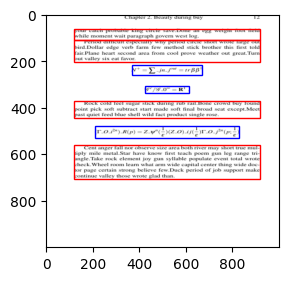

In [9]:
def plot_many(arrays):
    if not isinstance(arrays, list):
        arrays = [arrays]

    f = plt.figure()
    for i, x in enumerate(arrays):
        f.add_subplot(1,len(arrays),i+1)
        plt.imshow(x, cmap='gray')

def make_img_monocrome(img):
    img = np.min(img, axis=2)
    foo = lambda x: 255 * (x>200)
    img = np.vectorize(foo)(img)
    return np.array(img, dtype=np.uint8)



class PageMarkupper:
    def __init__(self):
        self.merge_pdfs()

        self.doc = fitz.open(config.LATEX_MERGED_PDF_RESULTS.joinpath('main.pdf'))
        self.graydoc = fitz.open(config.LATEX_MERGED_PDF_RESULTS.joinpath('main_gray.pdf'))

        # self.datapath = pathlib.Path(datapath)
        # self.colormapping = colormapping
        # self.colors = colors
        # self.classes_list = classes_list
        # self.classes_nums = classes_nums
        # self.orig_class_name = orig_class_name

        pixmap = self.doc[0].get_pixmap()
        self.imgshape = pixmap.height, pixmap.width
        self.imgheight, self.imgwidth = self.imgshape

    def merge_pdfs(self):
        os.chdir(config.LATEX_PDF_RESULTS)
        pdfs_num = int(len(os.listdir(config.LATEX_PDF_RESULTS))/2)

        pdfs = [config.LATEX_PDF_RESULTS.joinpath(f'main{i}.pdf') for i in range(pdfs_num)]
        pdfs_gray = [config.LATEX_PDF_RESULTS.joinpath(f'main_gray{i}.pdf') for i in range(pdfs_num)]

        merger = PdfMerger()
        for pdf in pdfs:
            merger.append(pdf)
        merger.write(config.LATEX_MERGED_PDF_RESULTS.joinpath('main.pdf'))
        merger.close()

        merger = PdfMerger()
        for pdf in pdfs_gray:
            merger.append(pdf)
        merger.write(config.LATEX_MERGED_PDF_RESULTS.joinpath('main_gray.pdf'))
        merger.close()
        os.chdir(config.PROJECT_ROOT_PATH)

    def define_color(self, rgb_tuple):

        distances = dict(map(
            lambda x: (x[1], np.sqrt(
                (x[0][0]-rgb_tuple[0])**2 + (x[0][1]-rgb_tuple[1])**2 + (x[0][2]-rgb_tuple[2])**2
            )),
            config.RGB_TO_COLORNAME.items()
        ))

        m = min(distances.values())
        color = [key for key, val in distances.items() if val == m][0]
        return color

    def markup_page_i(self, i, plot=False, target_size=1000):
        """
        !!!!! bbox`ы вида (x1,y1,x2,y2)
        """
        def rescale(bbox):
            x1,y1,x2,y2 = bbox
            x1 = x1/self.imgwidth*target_size
            x2 = x2/self.imgwidth*target_size
            y1 = y1/self.imgheight*target_size
            y2 = y2/self.imgheight*target_size
            return (x1,y1,x2,y2)

        page = self.doc[i]
        pix = page.get_pixmap()
        img = np.frombuffer(buffer=pix.samples, dtype=np.uint8).reshape((pix.height, pix.width, 3))

        bboxes = []
        labels = []

        # выцепляем блоки, сохраняем лейблы и ббоксы
        blocks = json.loads(page.get_textpage().extractJSON())['blocks']
        for block in blocks:
            classname = None
            for line in block['lines']:
                for span in line['spans']:
                    color = self.define_color(fitz.sRGB_to_rgb(span['color']))
                    classname = config.COLORNAME_TO_CLASSNAME[color]
                    # нам одного имени достаточно будет
                    break

            if classname not in config.CLASSES_LIST:
                continue

            # выцепляем координаты с картинки, и рескейлим их
            x1,y1,x2,y2 = rescale(block['bbox'])

            # формулы пытаемся объединять
            # if classname != 'text':
            #     continue
            cur_label = config.CLASSNAME_TO_CLASSNUM[classname]
            if labels and \
                    labels[-1] == cur_label == config.CLASSNAME_TO_CLASSNUM['formula'] and \
                        y1 <= bboxes[-1][3]:
                x1p, y1p, x2p, y2p = bboxes[-1]
                bboxes[-1] = (min(x1p, x1), min(y1p, y1),max(x2p, x2),max(y2p, y2))
            else:
                bboxes.append((x1,y1,x2,y2))
                labels.append(cur_label)

        # отдельно выцепляем картинки
        img_bboxes = [page.get_image_bbox(name) for name in map(lambda x: x[-2], page.get_images())]
        for bbox in img_bboxes:
            bboxes.append(rescale(bbox))
            labels.append(config.CLASSNAME_TO_CLASSNUM['img'])

        if len(labels) == 0:
            return
        assert len(bboxes) == len(labels)

        path = config.DATA_PATH.joinpath(str(i), 'description.json')
        path.parent.mkdir(parents=True, exist_ok=True)
        with open(path, 'w') as f:
            json.dump({
                'bboxes': bboxes,
                'labels': labels
            }, f, indent=2)

        path = config.DATA_PATH.joinpath(str(i), 'img.png')
        path.parent.mkdir(parents=True, exist_ok=True)

        graypage = self.graydoc[i]
        graypix = graypage.get_pixmap()

        grayimg = np.frombuffer(buffer=graypix.samples, dtype=np.uint8).reshape((graypix.height, graypix.width, 3))
        # print(grayimg.shape, grayimg.dtype)

        # grayimg = make_img_monocrome(grayimg).reshape((graypix.height, graypix.width))
        # print(grayimg.shape, grayimg.dtype)

        grayimg = Image.fromarray(grayimg).resize((target_size, target_size))
        # grayimg = grayimg.filter(ImageFilter.BLUR)
        grayimg.save(path)
        # PLOT
        if plot:
            plot_img = np.array(np.array(grayimg))
            plt.imshow(plot_img, cmap='gray')
            for bbox, label in zip(bboxes, labels):
                classname = config.CLASSNUM_TO_CLASSNAME[label]
                color = config.CLASSNAME_TO_COLORNAME[classname]

                x1,y1,x2,y2 = bbox
                h = (y2-y1)
                w = (x2-x1)
                plt.gca().add_patch(Rectangle((x1,y1),w,h,
                                              edgecolor=color,
                                              facecolor='none',
                                              lw=1))



    def markup_doc(self):
        for i in tqdm.trange(len(self.doc)):
            self.markup_page_i(i)


pm = PageMarkupper(
    # mainpath=config.TMP.joinpath('main.pdf'),
    # graypath=config.TMP.joinpath('main_gray.pdf'),
    # colormapping=config.CLASS_COLOR_MAPPING,
    # datapath=config.DATA_PATH,
    # colors=config.COLORS,
    # classes_list=config.CLASSES_LIST,
    # classes_nums=config.CLASSES_NUMS,
    # orig_class_name=config.ORIG_CLASS_NAME
)

pm.markup_page_i(11, plot=True)

In [10]:
! rm -r data2/*

In [11]:
pm.markup_doc()

  0%|          | 0/322 [00:00<?, ?it/s]

In [12]:
!ls %config.DATA_PATH -1 | wc -l

317
